# database interface & plotting examples

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import boto3
import base64
import os
from botocore.exceptions import ClientError
import json
import psycopg2
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import sys
import traceback
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
class DB:
    """database interface class"""
    @staticmethod
    def connect(params: dict) -> [psycopg2.extensions.connection, psycopg2.extensions.cursor]:
        """
            @brief: connects to the database

            @params:
                params: dictionary of db connection parameters

            @returns:
                db: the database
                cur: the cursor
        """
        if "datasource.username" in params:
            temp = {
                "user": params["datasource.username"],
                "password": params["datasource.password"],
                "database": params["datasource.database"],
                "host": params["datasource.url"],
                "port": params["datasource.port"]
            }
            params = temp
        try:
            print("[INFO] connecting to db.")
            db = psycopg2.connect(**params)
            print("[INFO] connected.")
            cur = db.cursor()
        except Exception as e:
            print("[ERROR] failed to connect to db.")
            print(e)
            return []
        return [db, cur]

    @staticmethod
    def execute(sql_query: str, database: psycopg2.extensions.connection) -> pd.DataFrame:
        """
            @brief: shorthand sql style execution

            @params:
                sql_query: the query string to execute
                database: the database to execute on

            @returns: a pandas table of the query results
        """
        try:
            if('insert' in sql_query):
                print("insert here")
                pd.read_sql_query(sql_query, database)
            else:
                return pd.read_sql_query(sql_query, database)
        except Exception as e:
            print(e)
            print(traceback.print_exc())
            if ('NoneType' in str(e)):
                print("ignoring error")
            return pd.DataFrame()
        
    @staticmethod
    def get_tables(db: psycopg2.extensions.connection) -> pd.DataFrame:
        """Returns a DataFrame of the tables in a given database"""
        return DB.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""", db)

    @staticmethod
    def get_fields(tb: str, db: psycopg2.extensions.connection) -> pd.DataFrame:
        """Returns the fields (column headers) for a given table"""
        return DB.execute("""SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = '{}';""".format(tb), db)

    
class Utils:
    """
        @brief: static class for utility functions

        @definitions:
            get_aws_secret(secret_name, region_name)
    """

    @staticmethod
    def get_aws_secret(secret_name: str="", region_name: str="us-east-1") -> {}:
        """
            @brief: retrieves a secret stored in AWS Secrets Manager. Requires AWS CLI and IAM user profile properly configured.

            @input:
                secret_name: the name of the secret
                region_name: region of use, default=us-east-1

            @output:
                secret: dictionary
        """
        client = boto3.session.Session().client(service_name='secretsmanager', region_name=region_name)
        secret = '{"None": "None"}'
        if (len(secret_name) < 1):
            print("[ERROR] no secret name provided.")
        else:
            try:
                res = client.get_secret_value(SecretId=secret_name)
                if 'SecretString' in res:
                    secret = res['SecretString']
                elif 'SecretBinary' in res:
                    secret = base64.b64decode(res['SecretBinary'])
                else:
                    print("[ERROR] secret keys not found in response.")
            except ClientError as e:
                print(e)

        return json.loads(secret)

    @staticmethod
    def get_config(filename: str=r'', section: str='postgresql') -> {}:
        """
            @brief: [DEPRECIATED] parses a database configuration file

            @params:
                filename: configuraiton file with .ini extension
                section: the type of db

            @returns:
                config: dictionary of database configuration settings
        """
        from configparser import ConfigParser
        parser = ConfigParser()
        config = {}

        try:
            parser.read(filename)
        except:
            print("[ERROR] failed to read file. does it exist?")
            return config

        if parser.has_section(section):
            params = parser.items(section)
            for param in params:
                config[param[0]] = param[1]
        else:
            print('[ERROR] Section {0} not found in the {1} file'.format(section, filename))
            return config

        return config


In [3]:
params = Utils.get_aws_secret("/secret/uav_db")
db, cur =  DB.connect(params)
del(params)
DB.get_tables(db)

[INFO] connecting to db.
[INFO] connected.


,table_name
0,model_tb
1,uav_tb
2,system_parameter_tb
3,eqc_battery_tb
4,asset_type_tb
5,eq_motor_tb
6,degradation_parameter_tb
7,mission_tb
8,asset_tb
9,dc_motor_tb


## get a list of experiments & mission_ids

In [88]:
def get_all_experiments(res='all'):
    experiments_df = DB.execute("""select et.* from experiment_tb et where et.notes ilike '%new after meeting%';""", database=db)
    mission_ids = list(experiments_df['mission_ids'].values)
    mission_ids = [idx.split('-') for idx in mission_ids]
    mission_ids = [np.arange(int(x), int(y)) for x, y in mission_ids]
    mission_idx = [np.arange(1, len(x)+1) for x in mission_ids]
    
    if mission_ids[0][0] == 2348:
        mission_ids[0] = np.delete(mission_ids[0], np.argwhere(mission_ids[0]==2356))
        mission_idx[0] = np.delete(mission_idx[0], np.argwhere(mission_idx[0]==9))
    assert len(mission_idx) == len(mission_ids), "[ERROR] index mappings should be of same length"
    experiments = [(x, y) for x,y in zip(mission_ids, mission_idx)]
    if res is 'all':
        return experiments, experiments_df, mission_ids, mission_idx
    if res is 'mission':
        return mission_ids, mission_idx
    if res is 'experiments':
        return experiments
    else:
        return []
    
experiments, experiments_df, _, _ = get_all_experiments()

In [5]:
experiments_df

,id,mission_ids,notes
0,16,2348-2487,new after meeting
1,17,2488-2614,new after meeting
2,18,2615-2747,new after meeting
3,19,2748-2878,new after meeting


## access the mission and degredation data for a given experiment

In [89]:
experiment = 1 # 0 based
print(experiments_df['notes'].iloc[experiment])
mission_ids = experiments[experiment][0]
mission_idx = experiments[experiment][1]
mission_data_df = DB.execute(f"""select mt.* from mission_tb mt where mt.id >= {mission_ids[0]} and mt.id <= {mission_ids[-1]} order by mt.id asc;""", database=db)
mission_data_df['idx'] = mission_idx
mission_data_df = mission_data_df.drop(columns={'dt_start', 'dt_stop'})
print(len(mission_data_df))

new after meeting
126


### view summary statistics of the mission data

In [90]:
mission_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,126.0,2550.500000,36.517119,2488.0000,2519.250000,2550.50000,2581.750000,2613.0000
trajectory_id,126.0,3.000000,0.000000,3.0000,3.000000,3.00000,3.000000,3.0000
stop_code,126.0,2.857143,0.517135,1.0000,3.000000,3.00000,3.000000,3.0000
prior_rul,126.0,-1.000000,0.000000,-1.0000,-1.000000,-1.00000,-1.000000,-1.0000
flight_time,126.0,17.766247,0.301095,15.6500,17.836700,17.83710,17.837100,17.8375
distance,126.0,1296.204511,25.202610,1107.1650,1301.954250,1302.00180,1302.038975,1302.1127
z_end,126.0,0.419299,0.059165,0.2979,0.378450,0.43690,0.464725,0.4958
v_end,126.0,3.707977,0.403598,2.5007,3.561050,3.91830,3.990950,4.0168
avg_pos_err,126.0,1.238952,0.006645,1.1791,1.238325,1.23985,1.241400,1.2456
max_pos_err,126.0,3.366290,0.059058,3.2752,3.316000,3.35995,3.419075,3.4803


In [91]:
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
degradation_data_df.head()

,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,1795,2488,14.978832,0.65,0.0,0.0,0.001555,0.0003,0.0,0.0,0.237918,0.0005,0.0,0.0,2,2,1
1,1796,2489,13.685727,0.65,0.0,0.0,0.001081,0.0003,0.0,0.0,0.236609,0.0005,0.0,0.0,2,2,1
2,1797,2490,14.953315,0.65,0.0,0.0,0.001292,0.0003,0.0,0.0,0.237015,0.0005,0.0,0.0,2,2,1
3,1798,2491,15.139618,0.65,0.0,0.0,0.000929,0.0003,0.0,0.0,0.237556,0.0005,0.0,0.0,2,2,1
4,1799,2492,14.549411,0.65,0.0,0.0,0.001419,0.0003,0.0,0.0,0.239437,0.0005,0.0,0.0,2,2,1


## view summary statistics of the degradation data

In [92]:
degradation_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,126.0,1857.500000,3.651712e+01,1795.000000,1826.250000,1857.500000,1888.750000,1920.000000
mission_id,126.0,2550.500000,3.651712e+01,2488.000000,2519.250000,2550.500000,2581.750000,2613.000000
q_deg,126.0,13.553079,1.394212e+00,9.758104,12.580814,13.888839,14.603294,15.500000
q_var,126.0,0.650000,3.343965e-16,0.650000,0.650000,0.650000,0.650000,0.650000
q_slope,126.0,-0.036054,1.220307e-01,-0.364115,-0.110849,-0.014499,0.030188,0.291161
q_intercept,126.0,15.946598,1.059022e+01,-16.678452,10.600265,14.999384,20.734106,46.774761
r_deg,126.0,0.012242,1.492815e-02,0.000813,0.001731,0.004444,0.017701,0.056756
r_var,126.0,0.000300,1.088530e-19,0.000300,0.000300,0.000300,0.000300,0.000300
r_slope,126.0,0.000400,4.756778e-04,-0.000045,0.000036,0.000155,0.000710,0.001703
r_intercept,126.0,-0.028642,4.159931e-02,-0.158123,-0.049572,-0.004988,0.000404,0.004089


## some data exploration
### looking at correlations between average position error and motor degradation

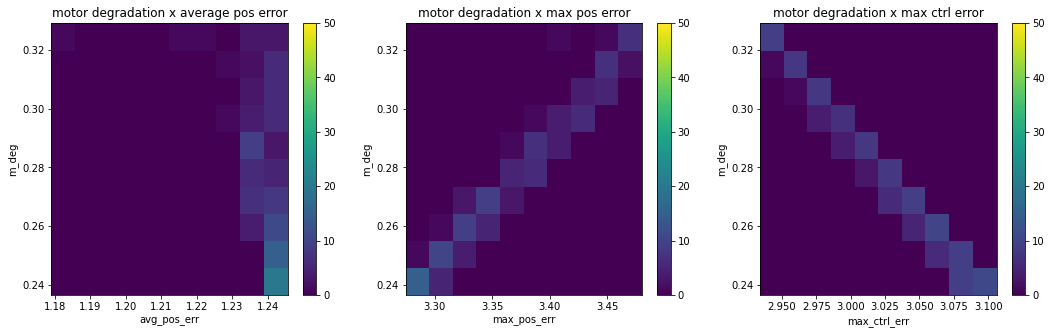

In [93]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist2d(mission_data_df['avg_pos_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('avg_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x average pos error")

plt.subplot(1,3,2)
plt.hist2d(mission_data_df['max_pos_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max pos error")

plt.subplot(1,3,3)
plt.hist2d(mission_data_df['max_ctrl_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_ctrl_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max ctrl error")

plt.show()

### what about correlations with the degradation rate of change?

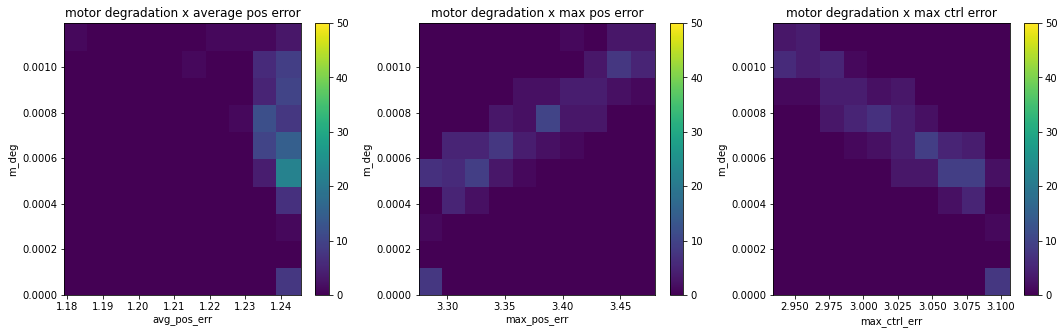

In [94]:
assert degradation_data_df['m_slope'].isnull().values.any() == False, "[WARN] fillna values on the m_slope column"
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist2d(mission_data_df['avg_pos_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('avg_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x average pos error")

plt.subplot(1,3,2)
plt.hist2d(mission_data_df['max_pos_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max pos error")

plt.subplot(1,3,3)
plt.hist2d(mission_data_df['max_ctrl_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_ctrl_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max ctrl error")

plt.show()

# view feature distributions

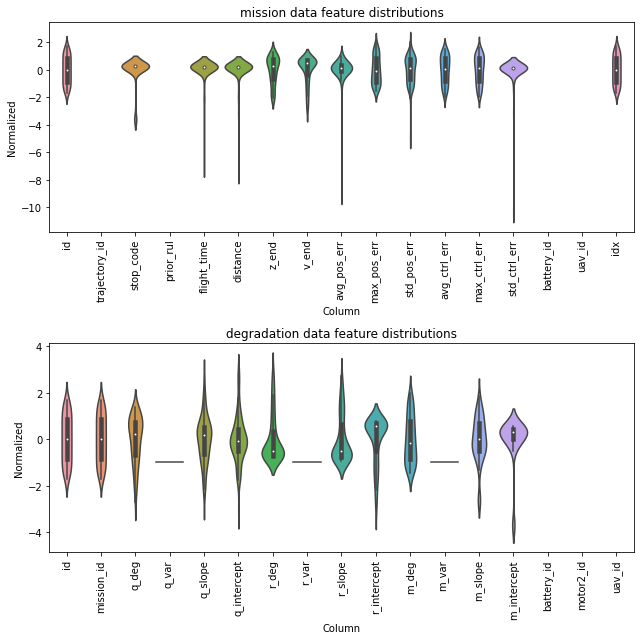

In [95]:
degradation_data_normalized = (degradation_data_df - degradation_data_df.mean()) / degradation_data_df.std()
mission_data_normalized = (mission_data_df - mission_data_df.mean()) / mission_data_df.std()

plt.figure(figsize=(9, 9))
plt.subplot(2,1,1)
mission_plt = mission_data_normalized.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=mission_plt)
_ = ax.set_xticklabels(mission_data_df.keys(), rotation=90)
plt.title("mission data feature distributions")

plt.subplot(2,1,2)
degradation_plt = degradation_data_normalized.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=degradation_plt)
_ = ax.set_xticklabels(degradation_data_df.keys(), rotation=90)
plt.title("degradation data feature distributions")
plt.tight_layout()

# view degradation parameter plots for a single experiment

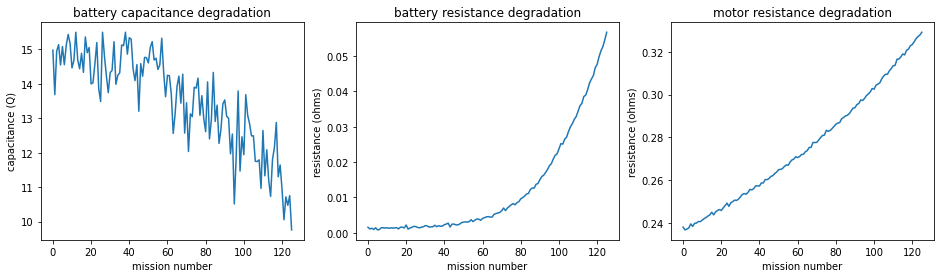

In [96]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
degradation_data_df['q_deg'].plot()
plt.title('battery capacitance degradation')
plt.xlabel('mission number')
plt.ylabel('capacitance (Q)')

plt.subplot(1,3,2)
degradation_data_df['r_deg'].plot()
plt.title('battery resistance degradation')
plt.xlabel('mission number')
plt.ylabel('resistance (ohms)')

plt.subplot(1,3,3)
degradation_data_df['m_deg'].plot()
plt.title('motor resistance degradation')
plt.xlabel('mission number')
plt.ylabel('resistance (ohms)')

plt.show()

In [101]:
mission_data_df['flight_time'].sum()

38.476461666666665

# view RUL (flight time) estimation plots for all experiments

0 new after meeting
1 new after meeting
2 new after meeting
3 new after meeting


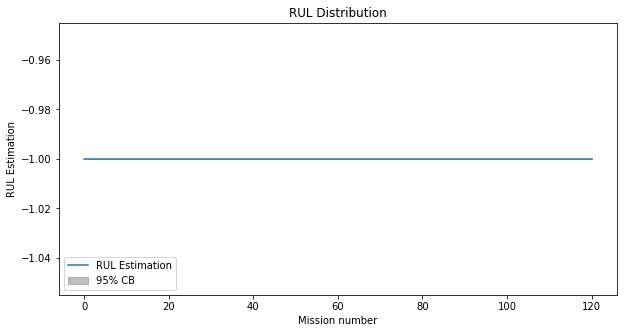

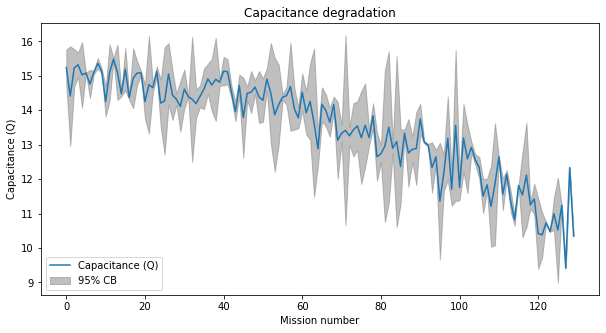

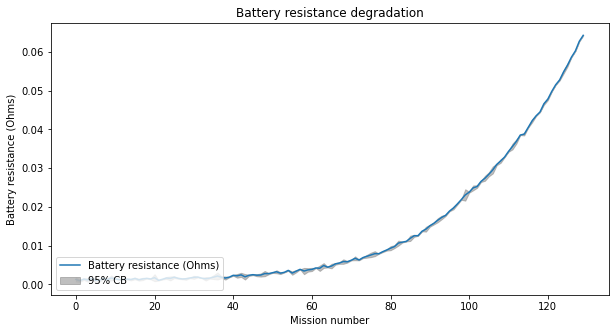

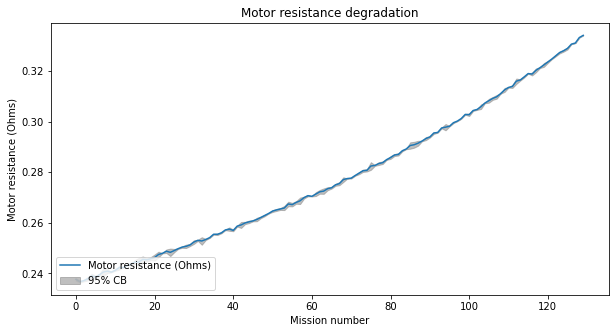

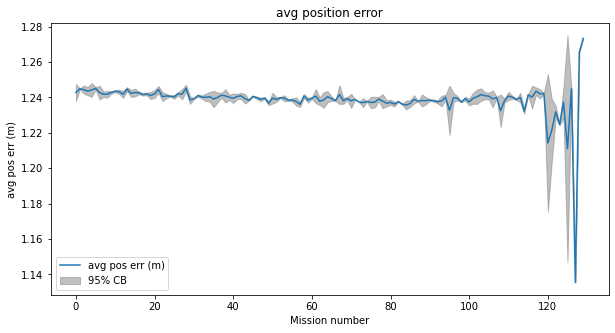

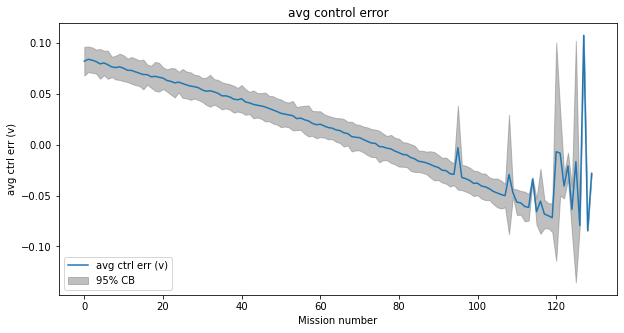

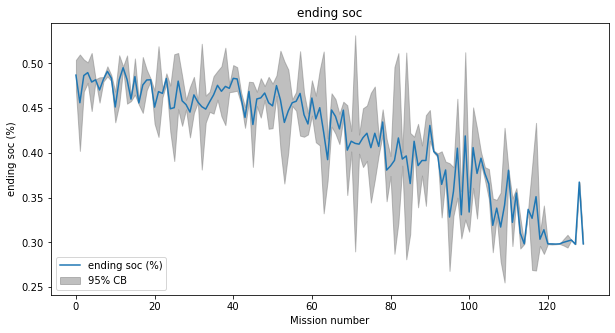

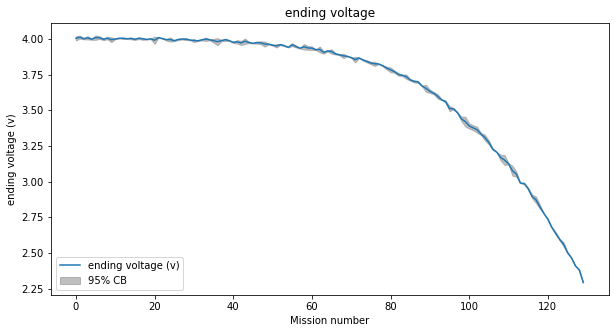

In [97]:
# get the rul from each experiment
ruls = []
q_degs = []
r_degs = []
m_degs = []
errs = []
ctrls = []
v_ends = []
z_ends = []

def get_samples(vals, exclude=[0,2]):
    samples = []    
    for i in range(0, max(len(val) for val in vals)):
        temp = []
        for j in range(0, len(vals)):
            if j in exclude:
                continue
            if(i < len(vals[j])):
                temp.append(vals[j][i])
        samples.append(temp)
    return samples


def plot_distribution(samples=[], 
                      return_distribution=True, 
                      label="RUL Estimation",
                      title="RUL Distribution",):
    mus = []
    stds = []

    # samples is a multi-dimensional list, where each index represents a run number
    # which always starts at 0 and increments until end of life, and at each index is 
    # a list of rul estimations from all experiments for that mission number
    # for example, there are 9 rul estimates at run number = 19, which contain
    # [16.5433, 18.9283, 17.7767, 18.2302, 17.0758, 16.7842, 17.5781, 17.4173, 17.0094]
    count = tf.Variable(0)
    for sample in samples:
        s = tf.convert_to_tensor(sample, dtype=tf.float32)
        count = count + len(s)
        mu = tf.math.reduce_mean(s, axis=0)
        std = tf.math.reduce_std(s, axis=0)
        #print(mu, std)
        mus.append(mu)
        stds.append(std)
    mu_t = tf.convert_to_tensor(mus, dtype=tf.float32)
    std_t = tf.convert_to_tensor(stds, dtype=tf.float32)


    plt.figure(figsize=(10,5))

    x = tf.range(0, mu_t.shape[0], delta=1)
    plt.fill_between(x, 
                     mu_t-2*std_t, 
                     mu_t+2*std_t, 
                     color='grey', 
                     alpha=.5, label="95% CB")
    plt.plot(x, mu_t, label=label)
    plt.ylabel(label)
    plt.xlabel('Mission number')
    plt.title(title)
    plt.legend(loc=3)
    #plt.text(-4, 11.8, f"*Calculated from data on {count} missions", backgroundcolor='white')
    plt.show()

    if return_distribution:
        return [mu_t, std_t]



for i in range(0, len(experiments)):
    print(i, experiments_df['notes'].iloc[i])
    mission_ids = experiments[i][0]
    mission_idx = experiments[i][1]

    mission_data_df = DB.execute(f"""select mt.* from mission_tb mt where mt.id >= {mission_ids[0]} and mt.id <= {mission_ids[-1]} order by mt.id asc;""", database=db)
    mission_data_df['idx'] = mission_idx
    mission_data_df = mission_data_df.drop(columns={'dt_start', 'dt_stop'})
    
    degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
    degradation_data_df = degradation_data_df.fillna(0)
    
    ruls.append(mission_data_df['prior_rul'].values)
    errs.append(mission_data_df['avg_pos_err'].values)
    ctrls.append(mission_data_df['avg_ctrl_err'].values)
    
    v_ends.append(mission_data_df['v_end'].values)
    z_ends.append(mission_data_df['z_end'].values)
    
    q_degs.append(degradation_data_df['q_deg'].values)
    r_degs.append(degradation_data_df['r_deg'].values)
    m_degs.append(degradation_data_df['m_deg'].values)
    
exclude=[0,2]
1 in exclude


    
samples=get_samples(ruls, exclude=[0,2])
rul_mu, rul_std = plot_distribution(samples=samples[9:-4], return_distribution=True)

samples=get_samples(q_degs, exclude=[0,2])
qd_mu, qd_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="Capacitance (Q)", 
                                 title="Capacitance degradation")

samples=get_samples(r_degs, exclude=[0,2])
rd_mu, rd_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="Battery resistance (Ohms)", 
                                 title="Battery resistance degradation")

samples=get_samples(m_degs, exclude=[0,2])
md_mu, md_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="Motor resistance (Ohms)", 
                                 title="Motor resistance degradation")

samples=get_samples(errs, exclude=[0,2])
ed_mu, ed_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="avg pos err (m)", 
                                 title="avg position error")

samples=get_samples(ctrls, exclude=[0,2])
ed_mu, ed_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="avg ctrl err (v)", 
                                 title="avg control error")

samples=get_samples(z_ends, exclude=[0,2])
ed_mu, ed_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="ending soc (%)", 
                                 title="ending soc")

samples=get_samples(v_ends, exclude=[0,2])
ed_mu, ed_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="ending voltage (v)", 
                                 title="ending voltage")

In [78]:
mission_data_df.head()
mission_data_df['index'] = mission_data_df.index
mission_data_df.head()

,id,trajectory_id,stop_code,prior_rul,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,battery_id,uav_id,idx,index
0,2748,3,3,-1.0,17.8342,1301.9967,0.4953,4.0114,1.2452,3.2577,0.6731,0.0892,3.1064,0.9820,2,1,1,0
1,2749,3,3,-1.0,17.8342,1301.8756,0.4829,4.0168,1.2450,3.2532,0.6734,0.0902,3.1064,0.9820,2,1,2,1
2,2750,3,3,-1.0,17.8367,1302.1578,0.4953,3.9987,1.2433,3.2636,0.6722,0.0894,3.1145,0.9820,2,1,3,2
3,2751,3,3,-1.0,17.8342,1301.9087,0.4953,4.0018,1.2447,3.2646,0.6727,0.0876,3.1067,0.9819,2,1,4,3
4,2752,3,3,-1.0,17.8342,1301.8793,0.4953,3.9957,1.2462,3.2731,0.6731,0.0868,3.1043,0.9820,2,1,5,4


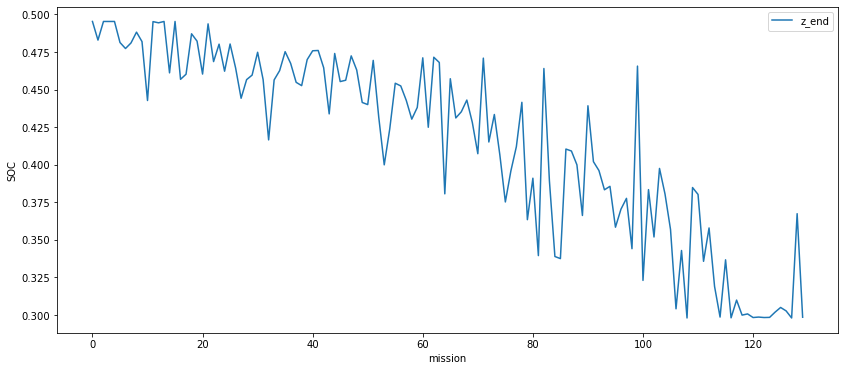

In [79]:
#mission_data_df['z_end'] = mission_data_df['z_end']/200
plt.figure(figsize=(14,6))
plt.plot(mission_data_df['z_end'], label='z_end')
#plt.scatter(x=mission_data_df.index, y=mission_data_df['trajectory_id'])
axe = plt.gca()
plt.legend()
plt.xlabel('mission')
plt.ylabel('SOC')
plt.show()

In [808]:
mission_data_df['trajectory_id'].unique().min()

3

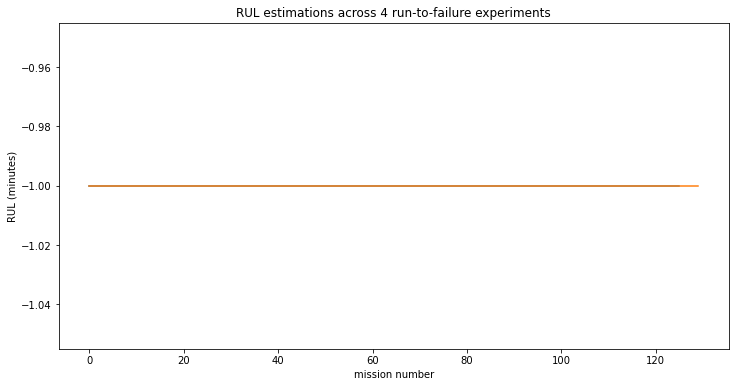

In [81]:
plt.figure(figsize=(12,6))
for i in range(0, len(ruls)):
    if i == 0 or i == 2:
        continue
    plt.plot(ruls[i])
    
    
plt.title(f"RUL estimations across {len(ruls)} run-to-failure experiments")
plt.ylabel("RUL (minutes)")
plt.xlabel("mission number")
plt.show()

# view degradation parameter plots for all runs

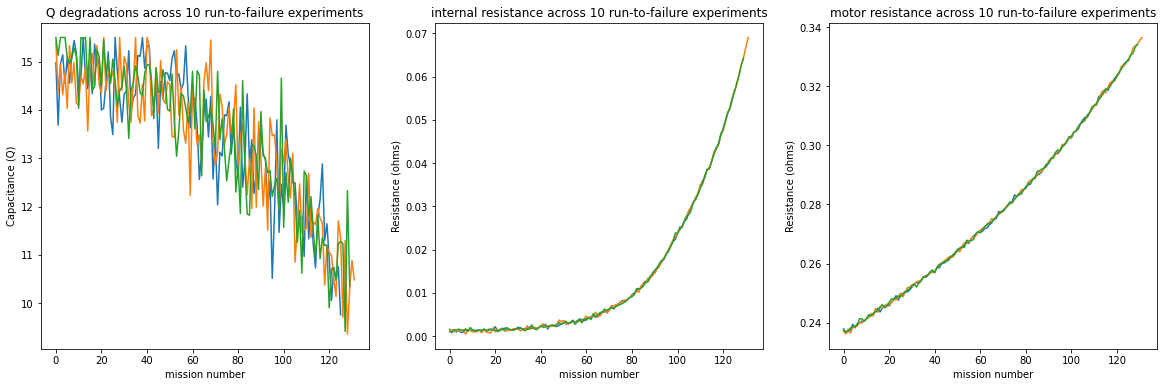

In [82]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
i = 0
for q in q_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(q)
    
plt.title("Q degradations across 10 run-to-failure experiments")
plt.ylabel("Capacitance (Q)")
plt.xlabel("mission number")

plt.subplot(1,3,2)
i = 0
for r in r_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(r)
    
plt.title("internal resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")

plt.subplot(1,3,3)
i = 0
for m in m_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(m)
    
plt.title("motor resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")

plt.show()

# look at the twin parameter data

In [20]:
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
twin_params_df.tail()

,id,mission_id,trajectory_id,rul_hat,flight_time,distance,v_end,z_end,avg_err,q_deg,r_deg,m_deg,stop1,stop2,stop3,uav_id
4043,4044,1551,20,17.461667,17.426667,1320.547308,3.904420,0.405843,1.453637,0.004846,12.859870,0.276714,1,0,0,1
4044,4045,1551,14,16.769167,14.834167,1099.691784,3.904003,0.489788,1.499260,0.004846,12.859870,0.276714,0,0,1,1
4045,4046,1551,14,16.769167,14.833333,1099.451839,3.910385,0.505285,1.485872,0.004844,13.263996,0.280576,0,0,1,1
4046,4047,1551,14,16.769167,14.833333,1099.399413,3.909785,0.499963,1.503915,0.004841,13.120078,0.274096,0,0,1,1
4047,4048,1551,14,16.769167,14.833333,1099.838904,3.914312,0.510384,1.511213,0.004714,13.409883,0.272416,0,0,1,1


## view voltage ending 

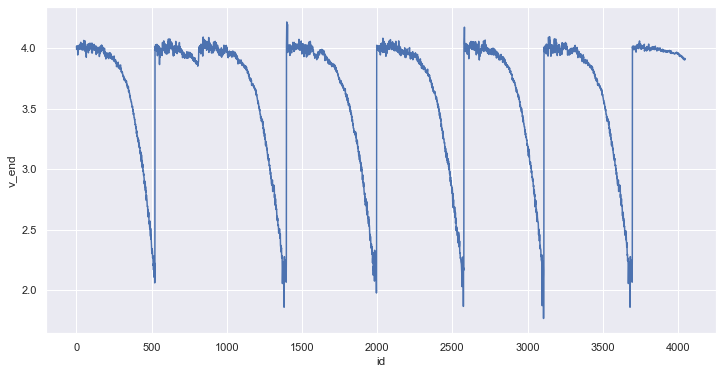

In [21]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=twin_params_df, x="id", y="v_end")
plt.show()

# view ending charge

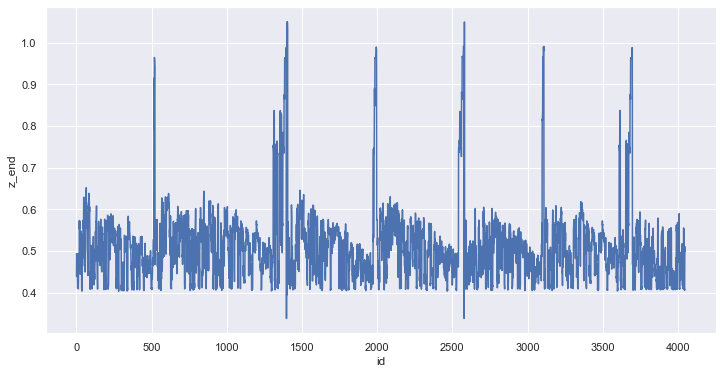

In [22]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=twin_params_df, x="id", y="z_end")
plt.show()

# view degradation slopes

In [23]:
degradation_data_df.head()

,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,1360,1360,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02000,0.0,0.0,2,2,1
1,1361,1361,15.500000,0.89,0.0,0.0,0.004678,0.00099,0.0,0.0,0.210102,0.01975,0.0,0.0,2,2,1
2,1362,1362,15.250537,0.88,0.0,0.0,0.000808,0.00098,0.0,0.0,0.222026,0.01950,0.0,0.0,2,2,1
3,1363,1363,14.300126,0.87,0.0,0.0,0.002619,0.00097,0.0,0.0,0.245294,0.01925,0.0,0.0,2,2,1
4,1364,1364,15.500000,0.86,0.0,0.0,0.000940,0.00096,0.0,0.0,0.223809,0.01900,0.0,0.0,2,2,1


In [84]:
%matplotlib inline
from IPython.display import HTML

import matplotlib.animation
import numpy as np

from scipy.signal import medfilt


def animate_degradation(deg, slope, intercept):
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    line, = ax.plot([], [], lw=2)
    plt.plot(deg)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)

    # animation function. This is called sequentially
    def animate(i):
        x = tf.range(start=i-2, limit=i+2, delta=.25)
        qm = slope[i]
        qb = intercept[i]
#         qm = degradation_data_df['q_slope'].iloc[i]
#         qb = degradation_data_df['q_intercept'].iloc[i]
        qy = qm * x + qb
        line.set_data(x, qy)
        return (line,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=len(slope), interval=50, blit=True)

    return HTML(anim.to_html5_video())

# single run to failure experiment battery capacitance degradation
- 128 missions in this case

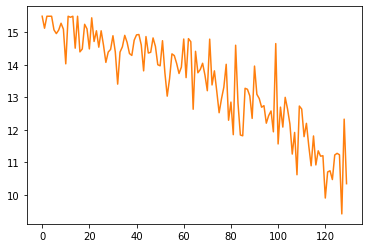

In [85]:
slope_filt = medfilt(degradation_data_df['q_slope'].values, 9)
inter_filt = medfilt(degradation_data_df['q_intercept'].values, 9)
animate_degradation(degradation_data_df['q_deg'], slope_filt, inter_filt)

# single run to failure experiment battery resistance degradation
- 128 missions in this case

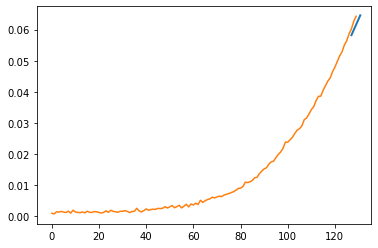

In [86]:
slope_filt = medfilt(degradation_data_df['r_slope'].values, 9)
inter_filt = medfilt(degradation_data_df['r_intercept'].values, 9)
animate_degradation(degradation_data_df['r_deg'], slope_filt, inter_filt)

# single run to failure experiment motor degradation

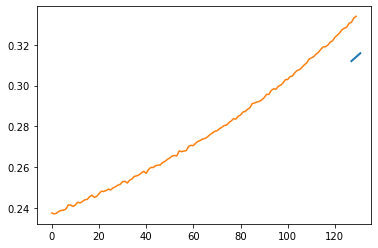

In [87]:
slope_filt = medfilt(degradation_data_df['m_slope'].values, 9)
inter_filt = medfilt(degradation_data_df['m_intercept'].values, 9)
animate_degradation(degradation_data_df['m_deg'], slope_filt, inter_filt)

# rul estimate of 14 experiments (1620 missions)
### view slope

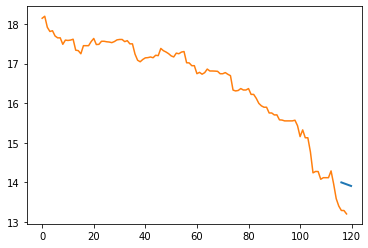

In [13]:
lookback = 8
horizon = 4
slopes = []
ints = []
for i in range(0, len(rul_mu)):
    if i <= lookback:
        slopes.append(0)
        ints.append(0)
    else:
        x = tf.range(start=i-lookback, limit=i, delta=1)
        y = rul_mu[x[0].numpy():x[-1].numpy()+1]
        z = np.polyfit(x.numpy(), y.numpy(), 1)
        slopes.append(z[0])
        ints.append(z[1])
    
slope_filt = medfilt(np.array(slopes), 9)
inter_filt = medfilt(np.array(ints), 9)
animate_degradation(rul_mu, slope_filt, inter_filt)

# clustering analysis

In [104]:
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering

stop1 = twin_params_df.pop('stop1')
stop2 = twin_params_df.pop('stop2')
stop3 = twin_params_df.pop('stop3')

In [110]:
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
print(len(degradation_data_df))
degradation_data_df.head()

1553


,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,1,1,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02500,0.0,0.0,2,2,1
1,2,2,13.877173,0.89,0.0,0.0,0.003257,0.00099,0.0,0.0,0.250991,0.02475,0.0,0.0,2,2,1
2,3,3,15.500000,0.88,0.0,0.0,0.001059,0.00098,0.0,0.0,0.171652,0.02450,0.0,0.0,2,2,1
3,4,4,14.934967,0.87,0.0,0.0,0.001094,0.00097,0.0,0.0,0.272745,0.02425,0.0,0.0,2,2,1
4,5,5,13.927817,0.86,0.0,0.0,0.001899,0.00096,0.0,0.0,0.264777,0.02400,0.0,0.0,2,2,1


# min max scale to range [0,1]

In [183]:
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
twin_params_df = (twin_params_df - twin_params_df.min()) / (twin_params_df.max() - twin_params_df.min())
degradation_data_df = (degradation_data_df - degradation_data_df.min()) / (degradation_data_df.max() - degradation_data_df.min())
X1 = twin_params_df[['v_end', 'z_end', 'avg_err']]
X2 = degradation_data_df[['q_deg', 'q_slope', 'q_intercept', 'r_deg', 'r_slope', 'r_intercept', 'm_deg', 'm_slope', 'm_intercept']]
#X2 = X2[X2['q_slope'] > 0]
Xs = [X1.values, X2.values]
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)

********************* twin params *******************


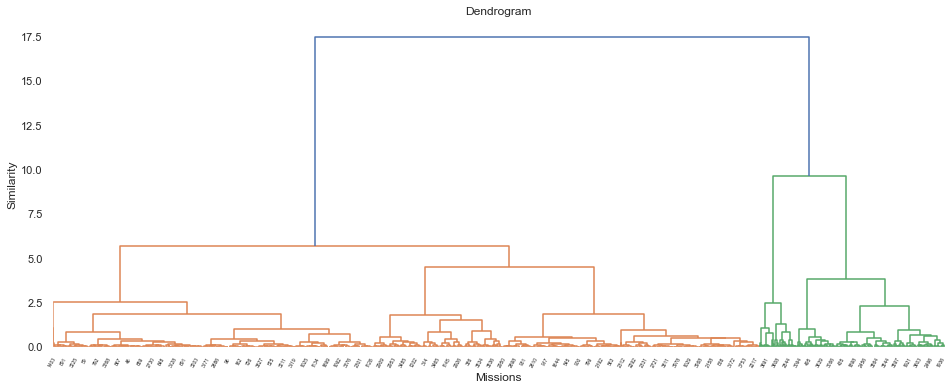

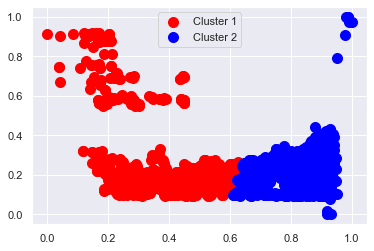

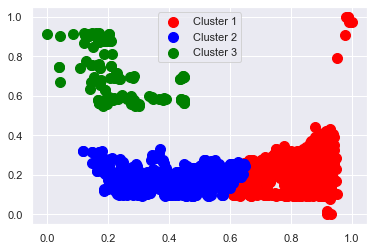

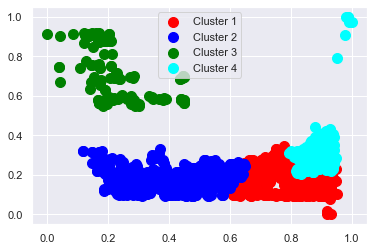

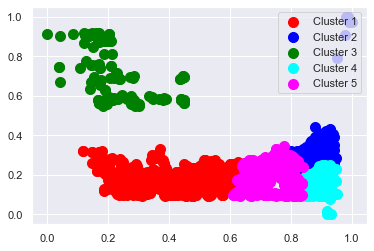

C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  f"KMeans is known to have a memory leak on Windows "


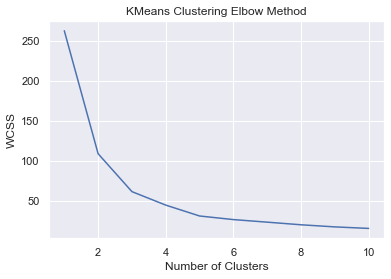

*********************************************************
********************* degradation data *******************


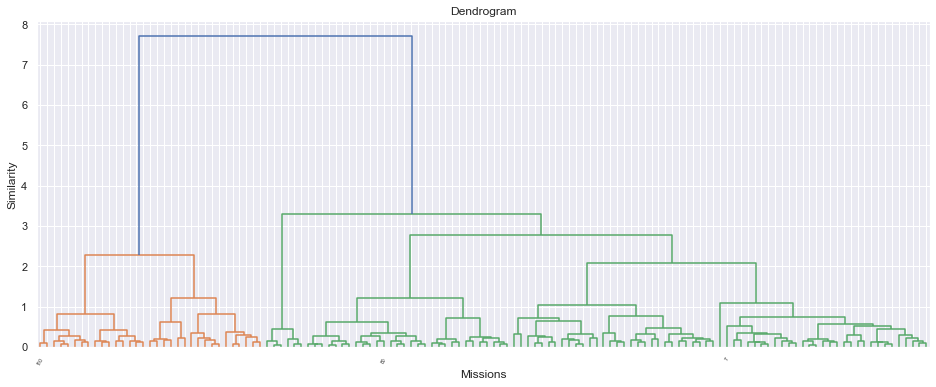

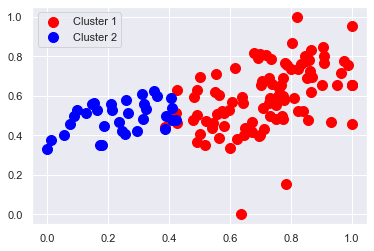

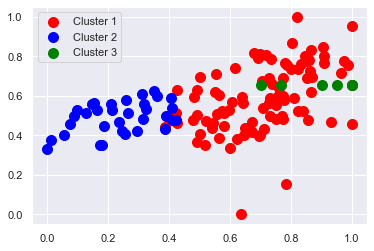

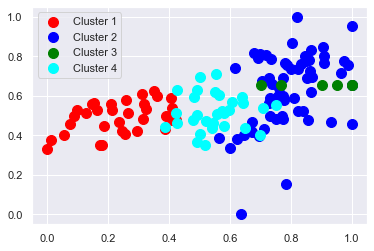

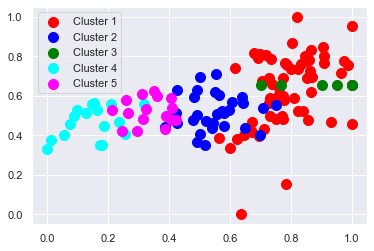

C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


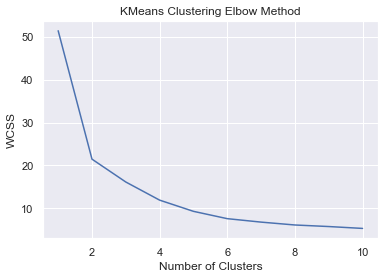

*********************************************************


In [184]:
%matplotlib inline
names = ["twin params", "degradation data"]
j = 0

keep_clusters = []

for X in Xs:
    
    print(f"********************* {names[j]} *******************")
    j = j + 1
    plt.figure(figsize=(16,6))
    dendrogram = hc.dendrogram(hc.linkage(X, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Missions')
    plt.ylabel("Similarity")
    ax = plt.gca()
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 50 != 0]
    plt.xticks(rotation=60)
    plt.show()
    
    clust2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    y_pred = clust2.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.legend()
    plt.show()

    clust3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
    y_pred = clust3.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
    plt.legend()
    plt.show()
    keep_clusters.append(clust3)

    clust4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
    y_pred = clust4.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
    plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
    plt.legend()
    plt.show()

    clust5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
    y_pred = clust5.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
    plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
    plt.scatter(X[y_pred == 4, 0], X[y_pred == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
    plt.legend()
    plt.show()

    from sklearn.cluster import KMeans
    wcss = []
    for i in range(1, 11):
        km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=31)
        km.fit(X)
        wcss.append(km.inertia_)

    plt.plot(range(1,11), wcss)
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.title("KMeans Clustering Elbow Method")
    plt.show()
    print("*********************************************************")

In [185]:
len(mission_data_df)

130

In [218]:
sum(mission_data_df['cluster'] == 3)

6

In [367]:
mission_data_df['cluster'] = keep_clusters[1].labels_
mission_data_df['cluster'] = mission_data_df['cluster'] + 1
len(mission_data_df[mission_data_df['stop_code'] == mission_data_df['cluster']])

11

In [239]:
twin_params_df['cluster'] = keep_clusters[0].labels_
twin_params_df['cluster'] = twin_params_df['cluster'] + 1

In [240]:
print(sum(stop1), sum(stop2), sum(stop3))
print(twin_params_df['cluster'].value_counts())

429 90 3531
1    3227
2     675
3     169
Name: cluster, dtype: int64


429 90 3531
3    3227
1     675
2     169
Name: cluster, dtype: int64


429 90 3531
3    3227
1     675
2     169
Name: cluster, dtype: int64
0.868828297715549
0.7209530827806436


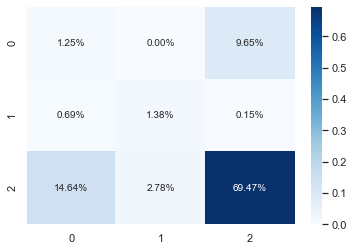

In [368]:
mission_data_df['cluster'] = keep_clusters[1].labels_
mission_data_df['cluster'] = mission_data_df['cluster'] + 1


twin_params_df['cluster'] = keep_clusters[0].labels_
twin_params_df['cluster'] = twin_params_df['cluster'] + 1
temp = twin_params_df[['stop1', 'stop2', 'stop3', 'cluster']].iloc[:]
temp['cluster'].replace({1:4}, inplace=True)
temp['cluster'].replace({2:1}, inplace=True)
temp['cluster'].replace({3:2}, inplace=True)
temp['cluster'].replace({4:3}, inplace=True)

print(sum(stop1), sum(stop2), sum(stop3))
print(temp['cluster'].value_counts())


actual = np.ones(len(temp), dtype=int)
for i in range(0, len(actual)):
    if temp['stop1'].iloc[i]:
        actual[i] = 1
    elif temp['stop2'].iloc[i]:
        actual[i] = 2
    elif temp['stop3'].iloc[i]:
        actual[i] = 3
    else:
        print("error")
        
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(actual, temp['cluster'].values)/len(temp['cluster'])
sns.heatmap(cm, annot=True, fmt=".2%", cmap='Blues')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict everything is 3
null_hypothesis = np.ones((len(temp['cluster']),))*3

res = null_hypothesis - actual
res[res != 0] = 1
sum(res)
print(1-sum(res)/len(res))

res = temp['cluster'].values - actual
res[res != 0] = 1
sum(res)
print(1-sum(res)/len(res))

# Feature selection of mission + degradation data on rul

In [63]:
def normalize(data_df):
    data_df = data_df[:]
    data_df = (data_df - data_df.min()) / (data_df.max() - data_df.min())
    return data_df

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RUL]')
  plt.legend()
  plt.grid(True)

In [40]:
data_df = DB.execute("select dpt.*, mt.* from degradation_parameter_tb dpt join mission_tb mt on mt.id = dpt.mission_id order by mission_id desc;", db)
data_df.head()
data_df[data_df.isnull().any(axis=1)]
data_df = data_df.fillna(0)
data_df[data_df.isnull().any(axis=1)]
data_df = data_df[data_df['prior_rul'] > 0]

In [41]:
y = data_df.pop('prior_rul').values
data_df.pop('id')
mid = data_df.pop('mission_id')
stp = data_df.pop('stop_code')
data_df.pop('dt_start')
data_df.pop('dt_stop')
data_df.pop('battery_id')
data_df.pop('uav_id')
data_df.pop('motor2_id')
#data_df = normalize(data_df)
X = data_df.values
data_df.head()

,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,...,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err
0,10.973540,0.25,-0.079162,20.954117,0.064178,0.0001,0.001749,-0.163624,0.335395,0.005,...,0.9121,69.4641,0.9668,2.4131,1.4966,2.7849,0.5128,0.7201,2.9286,0.8657
1,10.478152,0.25,-0.092328,22.517134,0.062589,0.0001,0.001715,-0.159339,0.332270,0.005,...,11.7921,890.4648,0.5254,2.3546,1.4515,3.6725,0.6726,0.2236,3.2601,1.0946
2,10.650947,0.25,-0.089567,22.193118,0.060135,0.0001,0.001640,-0.150143,0.334344,0.005,...,9.7404,656.1817,0.6092,0.9836,1.3294,5.2724,0.7164,0.2933,3.4855,1.0051
3,11.382871,0.25,-0.049539,17.418654,0.058179,0.0001,0.001602,-0.145503,0.331529,0.005,...,12.4625,929.1057,0.5285,2.4704,1.3498,3.3762,0.6866,0.4337,3.4760,0.9718
4,10.892924,0.25,-0.088574,22.104463,0.056724,0.0001,0.001571,-0.141748,0.333926,0.005,...,6.0217,433.5821,0.7575,2.5439,1.2452,3.7023,0.7655,0.6271,3.7969,0.8008


In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2

methods = ['mutual info', 'f regression']


freg = f_regression(X, y)
best = SelectKBest(score_func=mutual_info_regression, k=12)
best_features = best.fit(X, y)
mutual_info = pd.DataFrame(best_features.scores_)
cols_df = pd.DataFrame(data_df.columns)
scores_df = pd.concat([cols_df, mutual_info, pd.DataFrame(freg[0])], axis=1)

scores_df.columns = ['parameter',methods[0], methods[1]]

print(f"Importance by {methods[0]}")
scores_df.sort_values(by=methods[0], ascending=False)

Importance by mutual info


,parameter,mutual info,f regression
7,r_intercept,0.941974,2478.294092
4,r_deg,0.938005,2206.971420
16,v_end,0.927288,2091.648712
6,r_slope,0.891084,1416.915508
13,flight_time,0.882673,2081.693699
14,distance,0.862482,2184.476822
8,m_deg,0.772213,347.202145
0,q_deg,0.706209,1852.502793
5,r_var,0.695292,638.317807
20,avg_ctrl_err,0.681977,1115.891968


In [46]:
print(f"Importance by {methods[1]}")
scores_df.sort_values(by=methods[1], ascending=False)

Importance by f regression


,parameter,mutual info,f regression
7,r_intercept,0.941974,2478.294092
4,r_deg,0.938005,2206.971420
14,distance,0.862482,2184.476822
16,v_end,0.927288,2091.648712
13,flight_time,0.882673,2081.693699
0,q_deg,0.706209,1852.502793
6,r_slope,0.891084,1416.915508
20,avg_ctrl_err,0.681977,1115.891968
15,z_end,0.303879,741.415600
5,r_var,0.695292,638.317807


# Model evaluation

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns

# json dict to hold model information
model_results = {}

### get the data_df back in shape after altering it from feature selection methods

In [50]:
def get_data(db):
    data_df = DB.execute("select dpt.*, mt.* from degradation_parameter_tb dpt join mission_tb mt on mt.id = dpt.mission_id order by mission_id desc;", db)
    data_df = data_df.fillna(0)
    #data_df[data_df.isnull().any(axis=1)]
    data_df = data_df[data_df['prior_rul'] > 0]
    data_df = data_df.drop(columns=['id', 'battery_id', 'motor2_id', 'uav_id'])
    return data_df

data_df = get_data(db)
data_df.tail()

,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,...,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err
1615,5,13.927817,0.86,0.0,0.0,0.001899,0.00096,0.0,0.0,0.264777,...,16.3617,1218.7356,0.4833,3.9880,1.3421,3.4620,0.7247,0.1588,3.5650,1.0172
1616,4,14.934967,0.87,0.0,0.0,0.001094,0.00097,0.0,0.0,0.272745,...,17.6346,1283.8769,0.4784,4.0084,1.3431,3.7596,0.8461,0.0705,3.2933,1.0571
1617,3,15.500000,0.88,0.0,0.0,0.001059,0.00098,0.0,0.0,0.171652,...,17.8325,1301.9721,0.4868,4.0095,1.3173,3.4164,0.6756,0.1317,3.1493,1.0203
1618,2,13.877173,0.89,0.0,0.0,0.003257,0.00099,0.0,0.0,0.250991,...,17.8371,1302.1040,0.4361,3.9500,1.2476,3.2242,0.6687,0.0929,3.1642,0.9797
1619,1,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,...,17.8342,1301.9481,0.4780,4.0083,1.2455,3.2464,0.6710,0.1012,3.1186,0.9820


In [35]:
data_df.head().transpose()

,0,1,2,3,4
mission_id,1620,1619,1618,1617,1616
q_deg,10.9735,10.4782,10.6509,11.3829,10.8929
q_var,0.25,0.25,0.25,0.25,0.25
q_slope,-0.0791622,-0.0923275,-0.0895669,-0.0495393,-0.0885738
q_intercept,20.9541,22.5171,22.1931,17.4187,22.1045
r_deg,0.0641778,0.0625891,0.0601354,0.058179,0.0567235
r_var,0.0001,0.0001,0.0001,0.0001,0.0001
r_slope,0.00174926,0.00171475,0.00163983,0.00160169,0.001571
r_intercept,-0.163624,-0.159339,-0.150143,-0.145503,-0.141748
m_deg,0.335395,0.33227,0.334344,0.331529,0.333926


### Remove columns not needed for training

In [56]:
#data_df.pop('id')
#mid = data_df.pop('mission_id')
#stp = data_df.pop('stop_code')
#trj = data_df.pop('trajectory_id')
#data_df.pop('dt_start')
#data_df.pop('dt_stop')
#data_df.pop('battery_id')
#data_df.pop('uav_id')
#data_df.pop('motor2_id')
data_df.columns.tolist()

['q_deg',
 'q_var',
 'q_slope',
 'q_intercept',
 'r_deg',
 'r_var',
 'r_slope',
 'r_intercept',
 'm_deg',
 'm_var',
 'm_slope',
 'm_intercept',
 'prior_rul',
 'flight_time',
 'distance',
 'z_end',
 'v_end',
 'avg_pos_err',
 'max_pos_err',
 'std_pos_err',
 'avg_ctrl_err',
 'max_ctrl_err',
 'std_ctrl_err']

In [134]:
train_df = data_df.sample(frac=.8, random_state=tf.random.uniform(shape=[], minval=0, maxval=9999, dtype='int32').numpy())
train_mid = mid.loc[train_df.index]
test_df = data_df.drop(train_df.index)
test_mid = mid.loc[test_df.index]
train_labels = train_df.pop('prior_rul')
test_labels = test_df.pop('prior_rul')
train_df_mid = train_df.pop('mission_id')
test_df_mid = test_df.pop('mission_id')
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_df))

### Data features, 'prior_rul' is the predictor and removed for training

In [115]:
test_df.head(10)

,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,...,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err
4,10.892924,0.25,-0.088574,22.104463,0.056724,0.0001,0.001571,-0.141748,0.333926,0.005,...,6.0217,433.5821,0.7575,2.5439,1.2452,3.7023,0.7655,0.6271,3.7969,0.8008
6,11.130016,0.25,-0.078193,20.841302,0.052604,0.0001,0.001447,-0.127037,0.324903,0.005,...,4.2508,296.6650,0.8391,2.6536,1.4012,3.7051,0.7473,0.5233,3.6565,0.9823
11,11.434513,0.25,-0.025489,14.704447,0.045017,0.0001,0.001285,-0.108207,0.326988,0.005,...,13.4679,994.8698,0.4753,2.8659,1.2513,3.5851,0.7573,0.2246,3.8112,0.9958
12,11.336264,0.25,-0.040910,16.486230,0.043357,0.0001,0.001241,-0.103257,0.311140,0.005,...,14.9000,1116.6724,0.4275,2.8896,1.3780,3.6343,0.7494,0.1983,3.6951,1.0614
15,12.090988,0.25,-0.008708,12.915499,0.039346,0.0001,0.001174,-0.095786,0.315105,0.005,...,13.9342,1047.6623,0.4988,2.9805,1.3783,3.6270,0.7534,0.0518,3.6876,1.0975
18,11.901762,0.25,-0.036766,15.962195,0.035671,0.0001,0.001098,-0.087631,0.305617,0.005,...,15.5667,1166.0956,0.4286,3.0816,1.3740,3.6070,0.7362,0.1671,3.6722,1.0509
26,12.239181,0.25,-0.053917,17.851256,0.026565,0.0001,0.000902,-0.067432,0.308055,0.005,...,13.2842,979.8675,0.5349,3.3341,1.3732,4.5002,0.7276,0.2378,2.8504,1.0404
46,13.115990,0.25,-0.057508,17.861311,0.010888,0.0001,0.000401,-0.022826,0.292663,0.005,...,13.9358,1047.9869,0.5366,3.7477,1.3793,3.5804,0.7579,0.0691,3.6288,1.0751
50,12.811874,0.25,-0.088502,20.098413,0.009168,0.0001,0.000339,-0.018038,0.278803,0.005,...,16.3629,1218.9775,0.4402,3.7927,1.3480,3.5051,0.7253,0.1442,3.5963,1.0258
62,13.273163,0.25,-0.028262,15.446701,0.005514,0.0001,0.000179,-0.006777,0.279356,0.005,...,13.5833,1021.0967,0.5581,3.8967,1.3744,4.3832,0.7382,0.2307,2.9709,1.0360


# the model

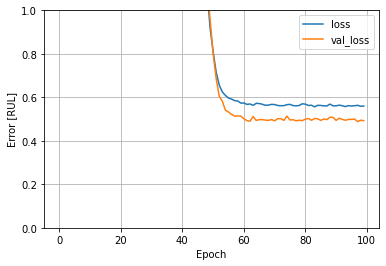

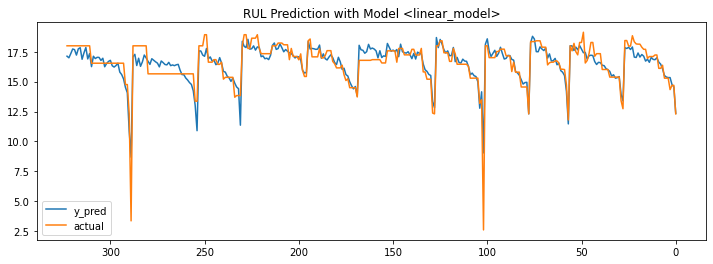

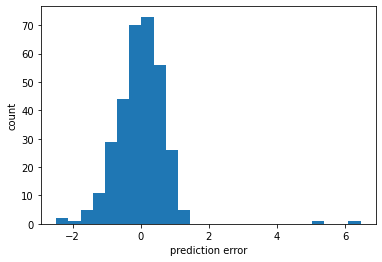

11/11 [==============================] - 0s 545us/step - loss: 0.5243


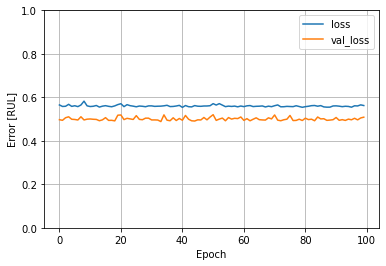

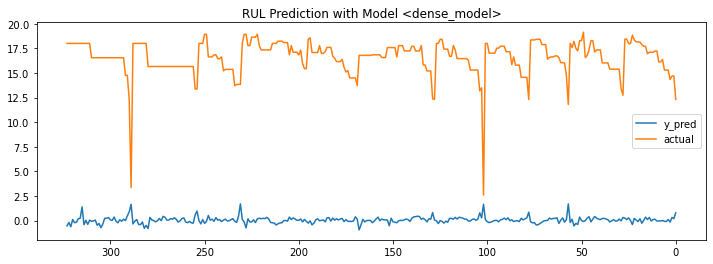

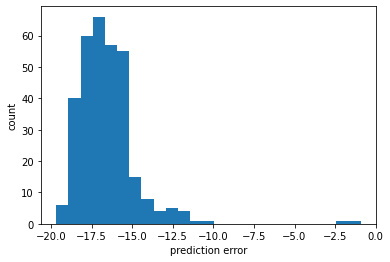

11/11 [==============================] - 0s 545us/step - loss: 16.5379


In [135]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_df))

learning_rate = .01
epochs        = 100
val_split     = .2


linear_model = tf.keras.Sequential([normalizer, 
                                    tf.keras.layers.Dense(units=1)])

dense_model = tf.keras.Sequential([normalizer, 
                                   tf.keras.layers.Dense(units=64, activation='relu'), 
                                   tf.keras.layers.Dense(units=64, activation='relu'),
                                   tf.keras.layers.Dense(units=1)])



names = ['linear_model', 'dense_model']
models = [linear_model, dense_model]

for model in zip(models, names):

    model[0].compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='mean_absolute_error')

    history = linear_model.fit(train_df, train_labels, verbose=0, epochs=epochs, validation_split=val_split)

    y_pred = model[0].predict(test_df)

    plot_loss(history)

    plt.figure(figsize=(12,4))
    plt.plot(y_pred, label='y_pred')
    plt.plot(test_labels.values, label='actual')
    plt.legend(loc='best')
    plt.title(f"RUL Prediction with Model <{model[1]}>")
    ax = plt.gca()
    ax.invert_xaxis()
    plt.show()
    
    error = y_pred.flatten() - test_labels.values
    plt.hist(error, bins=25)
    plt.xlabel('prediction error')
    _ = plt.ylabel('count')
    plt.show()
    
    model_results[model[1]] = [model[0].evaluate(test_df, test_labels, verbose=1), error]

### The above plot is test data from training a linear model (one fully connected layer) to predict RUL from the true system and degradation data using all parameters. There are 1,620 total missions, this test sample represents 20% of that. The training data consists of appx 1300 records, where each record contains data from a single mission. Over the last 14 experiments, the UAV typically reaches EOL at around the 130th mission, so the data set contains approximately 10 samples per mission index in range [0, ~130]. The features are listed below

## now reconstruct the mission indices to plot a distribution with 95% confidence bound

In [126]:
mission_ids, mission_idx = get_all_experiments(res='mission')
mission_ids = np.concatenate(mission_ids)
mission_idx = np.concatenate(mission_idx)
data_df['mission_id'] = mid

test_df['mission_id'] = test_mid
midx = []
for i in range(0, len(test_df)):
    _id = test_df['mission_id'].iloc[i]
    res = np.where(mission_ids == _id)[0]
    if len(res) > 0:
        midx.append(mission_idx[res[0]])
    else:
        print(i, _id, res)
        test_df = test_df[test_df['mission_id'] != _id]
len(midx)
len(test_df)
test_df['midx'] = midx
test_df = test_df.sort_values(by='midx')

test_mids = test_df.pop('mission_id')
test_midx = test_df.pop('midx')

In [106]:
train_df.columns.tolist()

['q_deg',
 'q_var',
 'q_slope',
 'q_intercept',
 'r_deg',
 'r_var',
 'r_slope',
 'r_intercept',
 'm_deg',
 'm_var',
 'm_slope',
 'm_intercept',
 'flight_time',
 'distance',
 'z_end',
 'v_end',
 'avg_pos_err',
 'max_pos_err',
 'std_pos_err',
 'avg_ctrl_err',
 'max_ctrl_err',
 'std_ctrl_err',
 'mission_id']

In [128]:
y_pred = models[0].predict(test_df)
results = pd.DataFrame()
results['mission_id'] = test_mids
results['mission_idx'] = test_midx
results['actual'] = test_labels
results['y_pred'] = y_pred

In [120]:
results

,mission_id,mission_idx,actual,y_pred
989,631,1,18.0000,17.829363
260,1360,1,18.0000,17.804255
259,1361,2,19.4292,18.036314
127,1493,2,18.8433,17.818876
1298,321,2,18.0000,17.306370
...,...,...,...,...
396,1224,130,2.2838,10.155514
860,760,130,13.7188,12.891132
1303,317,130,13.3633,12.011038
263,1357,131,3.4002,9.842314


## Now that we are sorted by mission index, we can aggregate the predictions 

## make sure we have values for each mission index in the test data

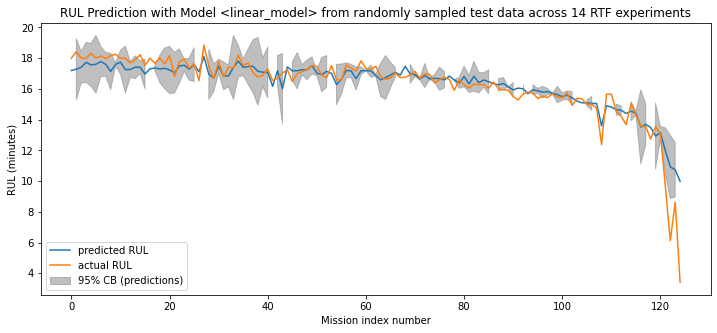

In [136]:
def update_missing(results):
    lst = results['mission_idx'].unique().tolist()
    missing = [x for x in range(lst[0], lst[-1]+1) if x not in lst]
    for i in range(0, len(missing)):
        results.loc[len(results)] = [-1, missing[i]]
    

def find_missing(lst):
    return [x for x in range(lst[0], lst[-1]+1) if x not in lst]

find_missing(results['mission_idx'].unique().tolist())

def plot_pred_dist(results):
    pred_mus = tf.convert_to_tensor(results.groupby("mission_idx").mean()['y_pred'].values, dtype='float32')
    pred_sds = tf.convert_to_tensor(results.groupby("mission_idx").std()['y_pred'].values, dtype='float32')

    act_mus = tf.convert_to_tensor(results.groupby("mission_idx").mean()['actual'].values, dtype='float32')
    act_sds = tf.convert_to_tensor(results.groupby("mission_idx").std()['actual'].values, dtype='float32')

    plt.figure(figsize=(12,5))

    x = tf.range(0, pred_mus.shape[0], delta=1)
    plt.fill_between(x, 
                     pred_mus-2*pred_sds, 
                     pred_mus+2*pred_sds, 
                     color='grey', 
                     alpha=.5, label="95% CB (predictions)")
    plt.plot(x, pred_mus, label="predicted RUL")
    plt.plot(x, act_mus, label="actual RUL")
    plt.ylabel("RUL (minutes)")
    plt.xlabel('Mission index number')
    plt.title(f"RUL Prediction with Model <{names[0]}> from randomly sampled test data across 14 RTF experiments")
    plt.legend(loc=3)
    #plt.text(-4, 11.8, f"*Calculated from data on {count} missions", backgroundcolor='white')
    plt.show()
    
plot_pred_dist(results)

In [382]:
len(test_labels)

324

In [378]:
# plt.figure(figsize=(12,4))
# plt.plot(y_pred, label='y_pred')
# #plt.plot(test_labels.values, label='actual')
# plt.legend(loc='best')
# plt.title(f"RUL Prediction with Model <{model[1]}> on test data across 14 RTF experiments")
# ax = plt.gca()
# plt.show()

## look at trajectory data

In [411]:
data_df = get_data(db)
print(data_df.columns.tolist())
data_df.head()

['id', 'mission_id', 'q_deg', 'q_var', 'q_slope', 'q_intercept', 'r_deg', 'r_var', 'r_slope', 'r_intercept', 'm_deg', 'm_var', 'm_slope', 'm_intercept', 'battery_id', 'motor2_id', 'uav_id', 'id', 'dt_start', 'dt_stop', 'trajectory_id', 'stop_code', 'prior_rul', 'flight_time', 'distance', 'z_end', 'v_end', 'avg_pos_err', 'max_pos_err', 'std_pos_err', 'avg_ctrl_err', 'max_ctrl_err', 'std_ctrl_err', 'battery_id', 'uav_id']


,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,...,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,battery_id,uav_id
0,1620,1620,10.973540,0.25,-0.079162,20.954117,0.064178,0.0001,0.001749,-0.163624,...,0.9668,2.4131,1.4966,2.7849,0.5128,0.7201,2.9286,0.8657,2,1
1,1619,1619,10.478152,0.25,-0.092328,22.517134,0.062589,0.0001,0.001715,-0.159339,...,0.5254,2.3546,1.4515,3.6725,0.6726,0.2236,3.2601,1.0946,2,1
2,1618,1618,10.650947,0.25,-0.089567,22.193118,0.060135,0.0001,0.001640,-0.150143,...,0.6092,0.9836,1.3294,5.2724,0.7164,0.2933,3.4855,1.0051,2,1
3,1617,1617,11.382871,0.25,-0.049539,17.418654,0.058179,0.0001,0.001602,-0.145503,...,0.5285,2.4704,1.3498,3.3762,0.6866,0.4337,3.4760,0.9718,2,1
4,1616,1616,10.892924,0.25,-0.088574,22.104463,0.056724,0.0001,0.001571,-0.141748,...,0.7575,2.5439,1.2452,3.7023,0.7655,0.6271,3.7969,0.8008,2,1


In [412]:
trajectory_df = pd.DataFrame()
trajectory_df['trajectory_id'] = data_df.pop('trajectory_id')
trajectory_df['stop_code'] = data_df.pop('stop_code')
trajectory_df.head()

,trajectory_id,stop_code
0,7,3
1,18,3
2,4,2
3,4,3
4,17,3


In [416]:
trajectory_df = trajectory_df.sort_values(['trajectory_id', 'stop_code'])
trajectory_df.head(10)

,trajectory_id,stop_code
1137,2,1
1092,2,1
1065,2,1
1059,2,1
1124,2,1
394,2,1
389,2,1
387,2,1
383,2,1
377,2,1


In [554]:
traj_df = trajectory_df.groupby(['trajectory_id', 'stop_code']).agg({'trajectory_id': ['min'], 'stop_code': ['min', 'count']})

trajectory_id = 2
count = 0

totals = []

for i in range(0, len(traj_df)):
    tid = int(traj_df.iloc[i].values[0])
    sc = int(traj_df.iloc[i].values[1])
    ct = int(traj_df.iloc[i].values[2])
    
    if tid == trajectory_id:
        count = count + ct
    else:
        totals.append(count)
        count = ct
        trajectory_id = tid
totals.append(count)

trajectory_id = 2
j = 0

newtotals = []

for i in range(0, len(traj_df)):
    tid = int(traj_df.iloc[i].values[0])
    sc = int(traj_df.iloc[i].values[1])
    if tid == trajectory_id:
        newtotals.append(totals[j])
    else:
        j = j + 1
        trajectory_id = tid
        newtotals.append(totals[j])

traj_df['totals'] = newtotals

pcts = []
for i in range(0, len(traj_df)):
    pct = traj_df.iloc[i].values[2] / traj_df.iloc[i].values[3]
    pcts.append(pct)
    
traj_df['pcts'] = pcts

trajectory_id = 2

ids = []

for i in range(0, len(traj_df)):
    tid = int(traj_df.iloc[i].values[0])
    if tid == trajectory_id:
        ids.append(tid)
    else:
        trajectory_id = tid
        ids.append(tid)
traj_df['ids'] = ids
traj_df.head()


traj_df

trajectory_id stop_code       totals      pcts ids
                                  min       min count                     
trajectory_id stop_code                                                   
2             1                     2         1    12     16  0.750000   2
              3                     2         3     4     16  0.250000   2
3             1                     3         1    15    129  0.116279   3
              3                     3         3   114    129  0.883721   3
4             2                     4         2     4      9  0.444444   4
              3                     4         3     5      9  0.555556   4
5             1                     5         1     1     14  0.071429   5
              2                     5         2     2     14  0.142857   5
              3                     5         3    11     14  0.785714   5
6             1                     6         1    10     16  0.625000   6
              3                     6         3     6     16  0.375000   6
7             3                     7         3    16     16  1.000000   7
8             1                     8         1     2     43  0.046512   8
              2                     8         2     3     43  0.069767   8
              3                     8         3    38     43  0.883721   8
9             1                     9         1     2    117  0.017094   9
              2                     9         2     6    117  0.051282   9
              3                     9         3   109    117  0.931624   9
10            2                    10         2    64    235  0.272340  10
              3                    10         3   171    235  0.727660  10
11            1                    11         1     9    244  0.036885  11
              2                    11         2     5    244  0.020492  11
              3                    11         3   230    244  0.942623  11
13            2                    13         2     1    267  0.003745  13
              3                    13         3   266    267  0.996255  13
14            1                    14         1     1    336  0.002976  14
              2                    14         2     1    336  0.002976  14
              3                    14         3   334    336  0.994048  14
15            1                    15         1    20    117  0.170940  15
              2                    15         2     3    117  0.025641  15
              3                    15         3    94    117  0.803419  15
16            2                    16         2     2     13  0.153846  16
              3                    16         3    11     13  0.846154  16
17            3                    17         3     7      7  1.000000  17
18            2                    18         2     3     15  0.200000  18
              3                    18         3    12     15  0.800000  18
19            2                    19         2     1      9  0.111111  19
              3                    19         3     8      9  0.888889  19
20            1                    20         1     7     15  0.466667  20
              3                    20         3     8     15  0.533333  20

In [555]:
ids = traj_df.pop('ids')
tmin = traj_df.pop('trajectory_id')
totals = traj_df.pop('totals')
scs = traj_df.pop('stop_code')
traj_df

pcts
                                 
trajectory_id stop_code          
2             1          0.750000
              3          0.250000
3             1          0.116279
              3          0.883721
4             2          0.444444
              3          0.555556
5             1          0.071429
              2          0.142857
              3          0.785714
6             1          0.625000
              3          0.375000
7             3          1.000000
8             1          0.046512
              2          0.069767
              3          0.883721
9             1          0.017094
              2          0.051282
              3          0.931624
10            2          0.272340
              3          0.727660
11            1          0.036885
              2          0.020492
              3          0.942623
13            2          0.003745
              3          0.996255
14            1          0.002976
              2          0.002976
              3          0.994048
15            1          0.170940
              2          0.025641
              3          0.803419
16            2          0.153846
              3          0.846154
17            3          1.000000
18            2          0.200000
              3          0.800000
19            2          0.111111
              3          0.888889
20            1          0.466667
              3          0.533333

# Update trajectory csv

In [6]:
res = DB.execute("select * from trajectory_tb;", db)
res.to_csv(r'trajectories.csv')

In [556]:
traj_us = traj_df.unstack().fillna(0)
traj_us.head()

pcts                    
                                           
stop_code             1         2         3
trajectory_id                              
2              0.750000  0.000000  0.250000
3              0.116279  0.000000  0.883721
4              0.000000  0.444444  0.555556
5              0.071429  0.142857  0.785714
6              0.625000  0.000000  0.375000

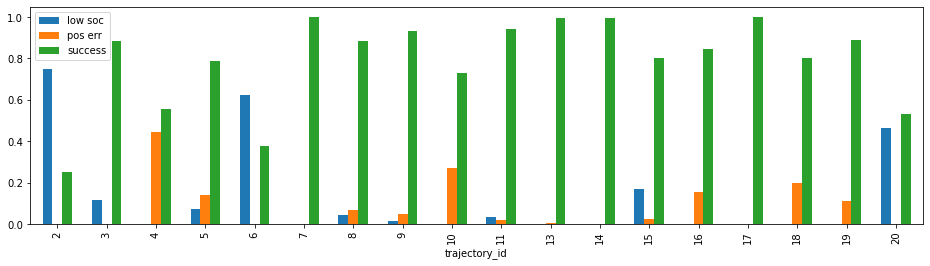

In [579]:
fig, ax = plt.subplots()
traj_us.plot(kind='bar', width=.6, align='center', ax=ax, figsize=(16,4))
ax.legend(["low soc", "pos err", "success"])

In [586]:
trajectory_df = DB.execute("select tt.* from trajectory_tb tt order by path_time desc;", db)
trajectory_df.sort_values(by='path_time', ascending=False)

,id,path_distance,path_time,risk_factor,x_waypoints,y_waypoints,x_ref_points,y_ref_points,sample_time,reward
0,12,1641.73,21.05,0.01,"[450.0, 330.0, 80.0, 120.0, 45.0]","[50.0, 230.0, 375.0, 240.0, 165.0]","[49.74, 49.58, 49.52, 49.55, 49.66, 49.85, 50....","[24.45, 24.12, 23.98, 24.04, 24.28, 24.69, 25....",1,1.0
1,1,1637.12,20.99,0.01,"[30.0, 200.0, 100.0, 410.0, 450.0, 200.0]","[150.0, 235.0, 350.0, 380.0, 50.0, 30.0]","[50.7, 51.4, 52.09, 52.78, 53.45, 54.12, 54.78...","[24.81, 24.94, 25.37, 26.1, 27.09, 28.33, 29.7...",1,1.0
2,2,1553.56,19.92,0.01,"[30.0, 100.0, 410.0, 450.0, 200.0]","[150.0, 350.0, 380.0, 50.0, 30.0]","[49.17, 48.52, 48.02, 47.67, 47.46, 47.38, 47....","[24.46, 24.11, 23.94, 23.95, 24.12, 24.46, 24....",1,1.0
3,20,1532.93,19.65,0.01,"[70.0, 200.0, 100.0, 440.0, 120.0, 45.0]","[90.0, 345.0, 350.0, 380.0, 240.0, 165.0]","[50.68, 51.33, 51.97, 52.58, 53.18, 53.76, 54....","[24.77, 24.75, 24.92, 25.28, 25.82, 26.52, 27....",1,1.0
4,6,1466.96,18.81,0.01,"[30.0, 200.0, 100.0, 410.0, 200.0]","[150.0, 235.0, 350.0, 380.0, 30.0]","[50.51, 51.04, 51.59, 52.14, 52.7, 53.27, 53.8...","[25.94, 26.94, 27.99, 29.1, 30.25, 31.45, 32.6...",1,1.0
5,3,1390.64,17.83,0.01,"[30.0, 100.0, 410.0, 200.0]","[150.0, 350.0, 380.0, 30.0]","[51.07, 52.08, 53.04, 53.94, 54.79, 55.59, 56....","[25.49, 26.0, 26.52, 27.07, 27.63, 28.22, 28.8...",1,1.0
6,15,1375.04,17.63,0.01,"[260.0, 440.0, 330.0, 80.0, 120.0, 45.0]","[80.0, 190.0, 230.0, 375.0, 240.0, 165.0]","[48.97, 48.18, 47.62, 47.27, 47.12, 47.15, 47....","[24.68, 24.56, 24.62, 24.86, 25.26, 25.81, 26....",1,1.0
7,11,1277.49,16.38,0.01,"[450.0, 330.0, 80.0, 120.0]","[50.0, 230.0, 375.0, 240.0]","[49.98, 50.01, 50.1, 50.25, 50.45, 50.69, 50.9...","[24.1, 23.4, 22.88, 22.54, 22.38, 22.37, 22.52...",1,1.0
8,14,1155.53,14.81,0.01,"[260.0, 330.0, 80.0, 120.0, 45.0]","[80.0, 230.0, 375.0, 240.0, 165.0]","[49.18, 48.53, 48.05, 47.72, 47.54, 47.5, 47.5...","[25.25, 25.57, 25.95, 26.4, 26.92, 27.5, 28.14...",1,1.0
9,13,1087.02,13.94,0.01,"[330.0, 80.0, 120.0, 45.0]","[230.0, 375.0, 240.0, 165.0]","[50.28, 50.6, 50.98, 51.4, 51.85, 52.35, 52.86...","[25.29, 25.78, 26.46, 27.32, 28.34, 29.53, 30....",1,1.0


In [379]:
# conn = psycopg2.connect(dbname="tsdb", user="postgres",
#          password="8rK2Q@99Ad0uo!Wb",host="144.126.248.145",port=5432)
# cur = conn.cursor()

In [5]:
params = Utils.get_aws_secret("/secret/uav_db")
db, cur =  DB.connect(params)
del(params)
DB.get_tables(db)

[INFO] connecting to db.
[INFO] connected.


,table_name
0,model_tb
1,uav_tb
2,eqc_battery_tb
3,eq_motor_tb
4,degradation_parameter_tb
5,mission_tb
6,pg_stat_statements
7,battery_sensor_tb
8,flight_sensor_tb
9,experiment_tb
